In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sb

root = os.path.dirname(os.getcwd())
exa_root = '/home/jorgemarpa/data/'

# Metadata

In [20]:
meta = np.load('%s/imgs/PPD/param_arr_gridandfiller1.npy' % (exa_root))
meta = pd.DataFrame(meta, columns=['m_dust', 'Rc', 'f_exp', 'H0', 
                                   'Rin', 'sd_exp', 'a_max', 'inc'])
meta.head()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
0,1e-07,100.0,1.15,5.0,0.1,0.0,10.0,90.0
1,1e-07,100.0,1.15,5.0,0.1,-0.5,10.0,90.0
2,1e-07,100.0,1.15,5.0,0.1,-1.0,10.0,90.0
3,1e-07,100.0,1.15,5.0,1.0,-0.5,10.0,90.0
4,1e-07,100.0,1.15,5.0,1.0,-1.0,10.0,90.0


In [21]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53063 entries, 0 to 53062
Data columns (total 8 columns):
m_dust    53063 non-null object
Rc        53063 non-null object
f_exp     53063 non-null object
H0        53063 non-null object
Rin       53063 non-null object
sd_exp    53063 non-null object
a_max     53063 non-null object
inc       53063 non-null object
dtypes: object(8)
memory usage: 3.2+ MB


In [22]:
meta.describe()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
count,53063,53063,53063,53063,53063,53063,53063,53063
unique,1837,1991,454,151,100,3363,3363,13
top,0.001,100.0,1.15,20.0,0.1,-0.5,10.0,90.0
freq,15841,13715,9579,13745,13516,9447,12472,11101


In [ ]:
sb.pairplot(meta.sample(1000), diag_kind='hist')
plt.show()

# Synthetic Images

In [24]:
imgs = np.load('%s/imgs/PPD/img_array_gridandfiller1_norm.npy' % (exa_root))
#imgs = np.expand_dims(imgs, axis=1)
imgs.shape

(53063, 1, 187, 187)

In [25]:
print('Min ', imgs.min(), 'Max ', imgs.max())
print('Mean ', imgs.mean(), 'Std ', imgs.std())

Min  0.0 Max  1.0
Mean  1.3490943e-05 Std  0.00045990472


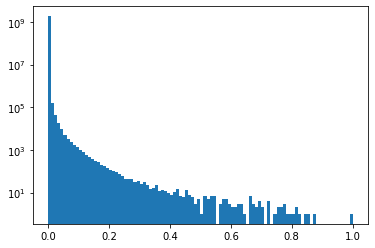

In [26]:
plt.hist(imgs.flatten(), bins=100, log=True)
plt.show()

In [27]:
def plot_wall(x):
    """Light-curves wall plot, function used during VAE training phase.
    Figure designed and ready to be appended to W&B logger.

    Parameters
    ----------
    xhat : numpy array
        Array of generated light curves
    x    : numpy array
        List of real light curves.
    epoch: int, optional
        Epoch number

    Returns
    -------
    fig
        a matplotlib figure
    image
        an image version of the figure
    """

    plt.close('all')
    ncols = 10
    v_min = np.min(x)
    v_max = np.max(x)
    norm = colors.SymLogNorm(linthresh=.0005, linscale=100,
                             vmin=v_min, vmax=v_max)
    print(v_min, v_max)
    fig, axis = plt.subplots(nrows=ncols, ncols=ncols, figsize=(ncols, ncols))
    for i, ax in enumerate(axis.ravel()):
        ax.imshow(x[i, 0, :, :], interpolation='bilinear',
                  cmap=cm.viridis, origin='upper', aspect='equal',
                  norm=norm)

    for ax in axis.ravel():
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)#, left=0, right=1)
    #plt.tight_layout()
    #fig.suptitle('Synthetic Images', fontsize=20, y=.95)
    plt.show()
    return

0.0 0.22920264


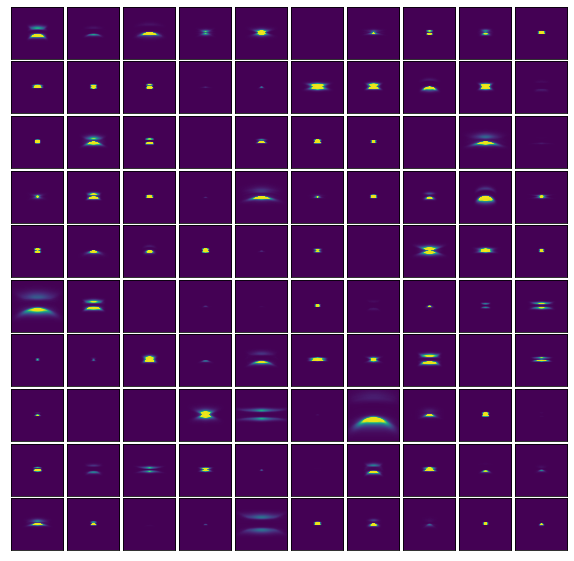

In [29]:
idx = np.random.randint(0, imgs.shape[0], size=100)
plot_wall(imgs[idx])

In [30]:
meta.iloc[idx].head()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
30893,0.001,100.0,1.3,20.0,0.1,-1.5,100.0,81.28480990202821
39741,3.71e-04,123.4,1.052,12.4,1.3,-0.6151352886944725,13.310218445210285,81.28480990202821
45477,3.40e-04,169.5,1.080,11.2,0.4,-0.03541373300203876,43.52091661991995,72.35936908636697
37774,1.41e-05,193.0,1.028,13.5,2.9,-1.041639698183101,114.72270494256951,90.0
1748,1e-06,300.0,1.3,15.0,1.0,-1.0,100.0,90.0


In [46]:
big = meta.query('m_dust == 0.001 and Rc == 300 and f_exp == 1.3 and H0 == 20').index.values
print(meta.iloc[big].shape)
meta.iloc[big].tail()

(452, 8)


,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
36513,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,78.344277
36514,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,81.284810
36515,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,84.202364
36516,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,87.104894
36517,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,90.000000


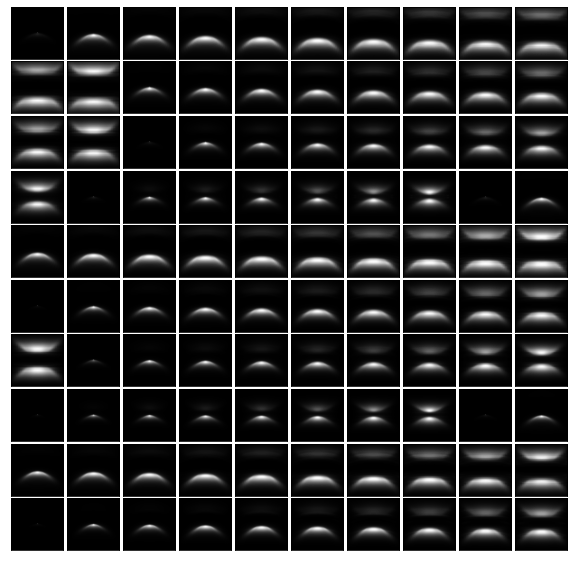

In [49]:
#plot_wall(imgs[np.random.choice(big, size=100, replace=False)])
plot_wall(imgs[big[:100]])

# Train / Val / Test splits

In [38]:
from sklearn.model_selection import train_test_split

In [61]:
train_idx, test_idx = train_test_split(np.arange(imgs.shape[0]), 
                                       test_size=.2, random_state=99)
train_idx.shape, test_idx.shape

((42450,), (10613,))

In [71]:
np.save('%s/imgs/PPD/param_arr_gridandfiller1_train.npy' % 
        (exa_root), meta.iloc[train_idx].values.astype(np.float32))
np.save('%s/imgs/PPD/param_arr_gridandfiller1_test.npy' % 
        (exa_root), meta.iloc[test_idx].values.astype(np.float32))

np.save('%s/imgs/PPD/img_array_gridandfiller1_norm_train.npy' % 
        (exa_root), imgs[train_idx])
np.save('%s/imgs/PPD/img_array_gridandfiller1_norm_test.npy' % 
        (exa_root), imgs[test_idx])

# Separate images by batches

In [83]:
n_batches = 5
batch_lims = np.linspace(0, train_idx.shape[0], n_batches+1, dtype=int)
print(batch_lims)

[    0  8490 16980 25470 33960 42450]


In [87]:
train_imgs = imgs[train_idx]
train_pars = meta.iloc[train_idx].values.astype(np.float32)

In [90]:
counter = 0
for k in range(n_batches):
    print([batch_lims[k] , batch_lims[k+1]])
    aux_img = train_imgs[batch_lims[k] : batch_lims[k+1]]
    aux_par = train_pars[batch_lims[k] : batch_lims[k+1]]
    print(aux_img.shape, aux_par.shape)
    counter += aux_img.shape[0]
    
    np.save('%s/imgs/PPD/param_arr_gridandfiller1_train_%i.npy' % 
        (exa_root, k+1), aux_par)
    np.save('%s/imgs/PPD/img_array_gridandfiller1_norm_train_%i.npy' % 
        (exa_root, k+1), aux_img)
    print('-----------------------')
    
print(counter)

[0, 8490]
(8490, 1, 187, 187) (8490, 8)
-----------------------
[8490, 16980]
(8490, 1, 187, 187) (8490, 8)
-----------------------
[16980, 25470]
(8490, 1, 187, 187) (8490, 8)
-----------------------
[25470, 33960]
(8490, 1, 187, 187) (8490, 8)
-----------------------
[33960, 42450]
(8490, 1, 187, 187) (8490, 8)
-----------------------
42450


In [95]:
train_imgs[42182], train_pars[42182]

(array([[[3.3664294e-14, 3.9188467e-14, 4.5644525e-14, ...,
          4.9280018e-14, 4.2231680e-14, 3.6464497e-14],
         [4.1011570e-14, 4.8524962e-14, 6.0227315e-14, ...,
          7.0670805e-14, 5.3179524e-14, 4.4683824e-14],
         [5.1758670e-14, 6.9626827e-14, 1.0154186e-13, ...,
          1.2193417e-13, 8.4122345e-14, 5.8808766e-14],
         ...,
         [5.7585731e-14, 7.5329859e-14, 9.8840281e-14, ...,
          1.1280010e-13, 8.6366312e-14, 6.5645162e-14],
         [4.4182275e-14, 5.0994829e-14, 6.3794713e-14, ...,
          7.2368577e-14, 5.6480702e-14, 4.7243015e-14],
         [3.5708554e-14, 4.0565556e-14, 4.5816659e-14, ...,
          4.9145184e-14, 4.3180781e-14, 3.8022852e-14]]], dtype=float32),
 array([ 1.00000e-03,  3.00000e+02,  8.50000e-01,  2.00000e+01,
         1.00000e+00, -1.00000e+00,  1.00000e+02,  6.61677e+01],
       dtype=float32))